# Forecast daily electricity prices for hedging

## Importing libraries
* <i>pandas</i> for data pre-processing.
* <i>numpy</i> for mathematical operations.
* <i>matplotlib.pyplot</i> and <i>pandas.plotting</i> for data visualization.
* <i>statsmodels</i> for visualizing statistical parameters and for building the model.

In [93]:
import pandas as pd

import numpy as np

from matplotlib import pyplot as plt

from statsmodels.tsa.stattools import adfuller, acf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt

## Importing dataset
* 3895 rows, 7 columns
* <i>"TradeDate"</i> and <i>"WtdAvgPrice"</i> are the main columns of interest.

In [48]:
data = pd.read_csv("data.csv", sep=';')
display(data.head())
print(data.shape)

,PriceHub,TradeDate,WtdAvgPrice,Change,DailyVolumeMWh,NumberTrades,NumberCounterparties
0,ABC,1/5/2001,125.5,NaN,800,2,2
1,ABC,1/8/2001,135.5,10.0,400,1,2
2,ABC,1/12/2001,175.0,39.5,800,1,2
3,ABC,1/19/2001,325.0,150.0,400,1,2
4,ABC,1/26/2001,245.0,-80.0,400,1,2


(3895, 7)


## Pre-processing dataset for time series analysis

### Converting <i>"TradeDate"</i> column to date-time format and checking for duplicates

In [49]:
series = data.drop(["PriceHub","Change","DailyVolumeMWh","NumberTrades","NumberCounterparties"], axis="columns")
series["TradeDate"] = pd.to_datetime(series["TradeDate"], infer_datetime_format = True)
series["TradeDate"].duplicated().sum()

30

### Removing duplicates
* Left with 3865/3895 rows.

In [50]:
useries = series.drop_duplicates(subset=["TradeDate"], keep='last')
display(useries["TradeDate"].duplicated().sum())
print(useries.shape)

0

(3865, 2)


### Setting <i>"TradeDate"</i> coulmn as index

In [51]:
useries.set_index(["TradeDate"], inplace=True)
useries.head()

,WtdAvgPrice
TradeDate,
2001-01-05,125.5
2001-01-08,135.5
2001-01-12,175.0
2001-01-19,325.0
2001-01-26,245.0


## Data Visualization

### Plotting time series

<AxesSubplot:xlabel='TradeDate'>

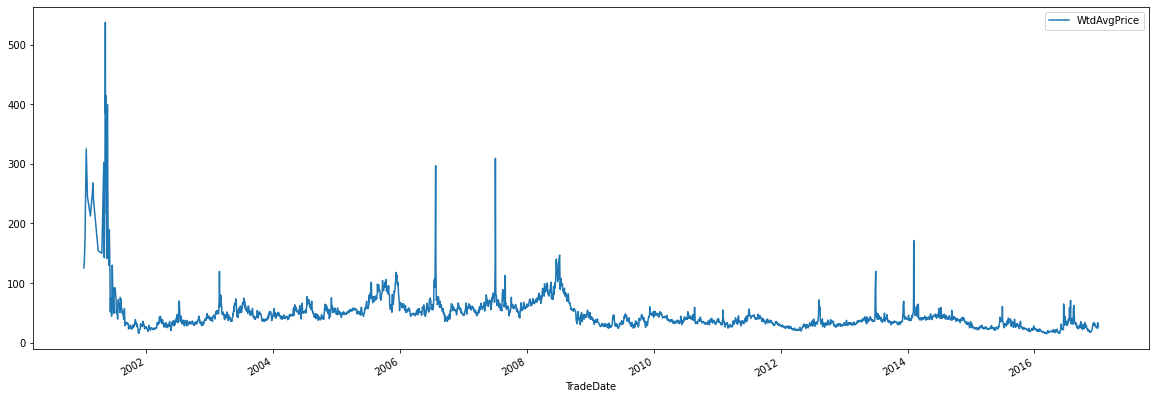

In [52]:
useries.plot(figsize=(20,7))

## Time series analysis and finding ARIMA parameters (p,d,q)

### Visualizing mean and std dev
* Apart from a few spikes, data shows somewhat random mean and constant standard deviation.

Text(0.5, 1.0, 'Rolling Mean and Standard Deviation')

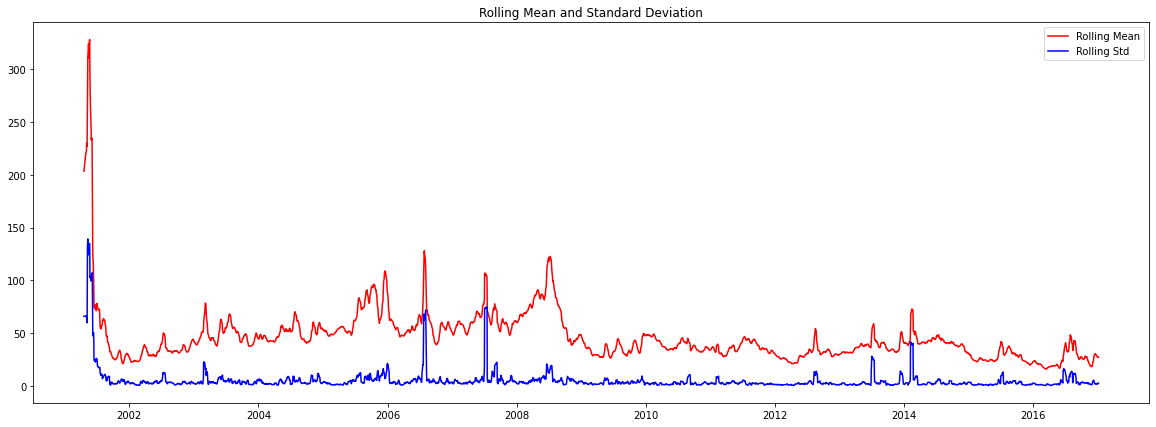

In [53]:
rolmean = useries.rolling(window=10).mean()
rolstd = useries.rolling(window=10).std()

fig = plt.figure(figsize=(20,7))
mean = plt.plot(rolmean, color = 'red', label = 'Rolling Mean')
std = plt.plot(rolstd, color = 'blue', label = 'Rolling Std')
plt.legend(loc = 'best')
plt.title('Rolling Mean and Standard Deviation')

### Augmented Dickey Fuller Test
* Checking for stationarity of the series.
* Since, p-value < 0.05, hence series is stationary.
* Furthermore, now in ARIMA, d=0.

In [54]:
result = adfuller(useries["WtdAvgPrice"])
print('ADF Statistic: {0}'.format(result[0]))
print('p-value: {0}'.format(result[1]))

ADF Statistic: -11.42623991796312
p-value: 6.684743293232503e-21


## Finding order of MA parameter (q)
* Plotting autocorrelation to find q.
* There is considerable spike in first 3 lags, hence q=3.

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

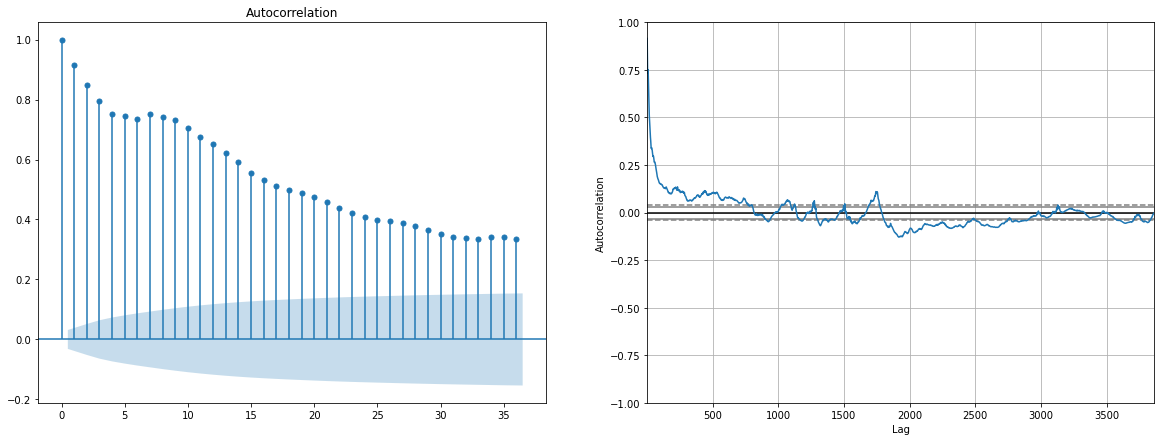

In [55]:
fig = plt.figure(figsize=(20,7))
ax = plt.subplot(1,2,1)
plot_acf(useries["WtdAvgPrice"], ax=ax)

plt.subplot(1,2,2)
autocorrelation_plot(useries["WtdAvgPrice"])

## Finding order of AR parameter (p)
* Plotting partial-autocorrelation to find q.
* There is considerable spike in first 2 lags, hence p=2.

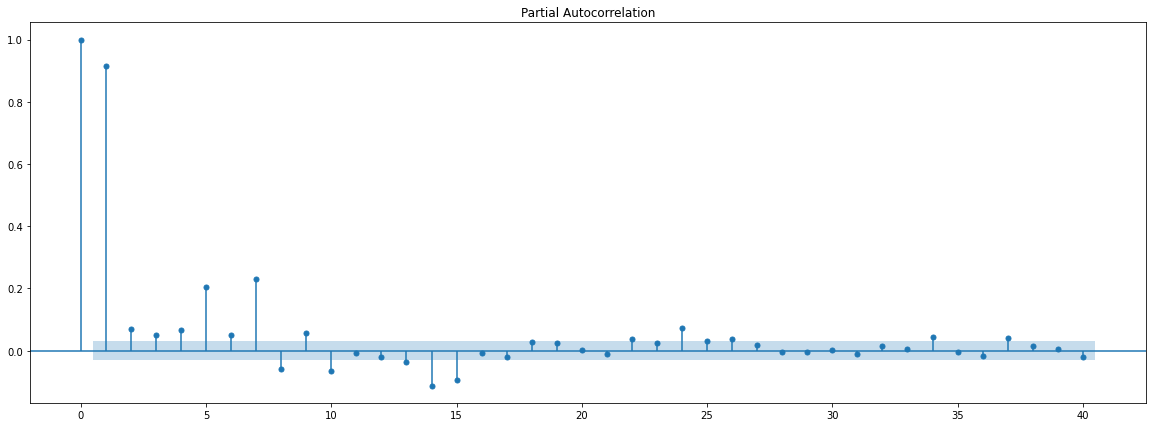

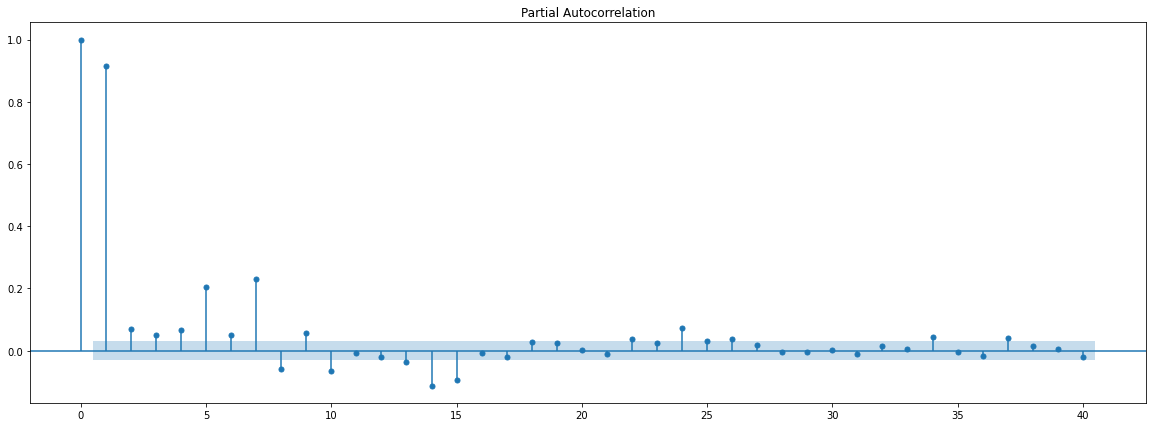

In [56]:
fig = plt.figure(figsize=(20,7))
ax = plt.subplot(1,1,1)
plot_pacf(useries, lags=40, ax=ax)

## Building the ARIMA model

In [57]:
model = ARIMA(useries, order=(2,0,3))
fit = model.fit()
print(fit.summary())

/home/chaupatt/.virtualenvs/ltts/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/home/chaupatt/.virtualenvs/ltts/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/home/chaupatt/.virtualenvs/ltts/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


                               SARIMAX Results                                
Dep. Variable:            WtdAvgPrice   No. Observations:                 3865
Model:                 ARIMA(2, 0, 3)   Log Likelihood              -14741.225
Date:                Sun, 18 Jul 2021   AIC                          29496.449
Time:                        16:08:50   BIC                          29540.267
Sample:                             0   HQIC                         29512.009
                               - 3865                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         45.9250      9.854      4.661      0.000      26.612      65.238
ar.L1          1.3449      0.014     93.045      0.000       1.317       1.373
ar.L2         -0.3512      0.014    -24.997      0.0

### Plotting residuals
* This is to ensure that there is no pattern in residuals.
* Density plot shows near 0 mean and uniform variance.

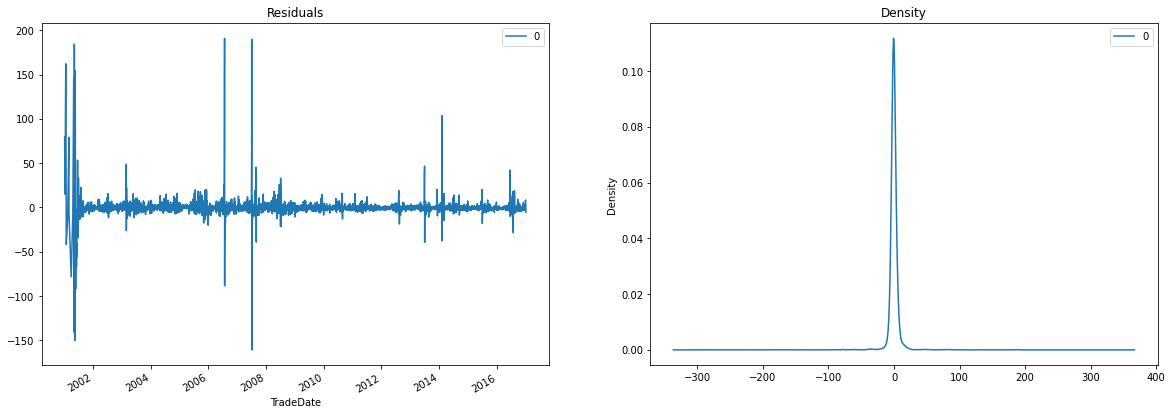

In [58]:
residuals = pd.DataFrame(fit.resid)

fig, ax = plt.subplots(1,2, figsize=(20,7))
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

## Validating model

### Creating training and testing data
* Reference [article](https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/).

/home/chaupatt/.virtualenvs/ltts/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/home/chaupatt/.virtualenvs/ltts/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/home/chaupatt/.virtualenvs/ltts/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/home/chaupatt/.virtualenvs/ltts/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model

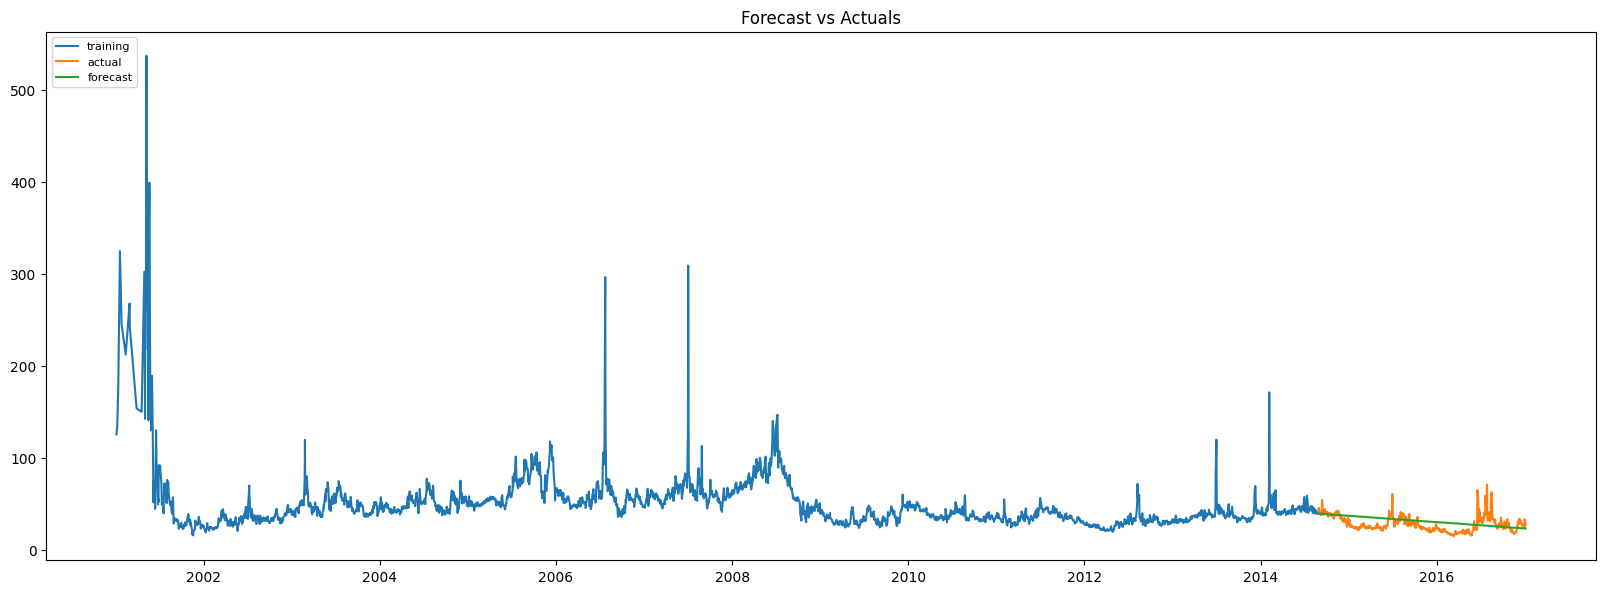

In [86]:
train = useries[:3285]
test = useries[3285:]

# model = ARIMA(train, order=(2,0,3)) #fitting too low, increasing d=2.
model = ARIMA(train, order=(2,2,3)) 
fit = model.fit()

fc = fit.forecast(580).to_list()

fc_series = pd.Series(fc, index=test.index)

plt.figure(figsize=(20,7), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)

### Calculating accuracy
* Model is 71.13% accurate

In [104]:
rmse = sqrt(mean_squared_error(test, fc_series))
print(rmse)
fc_series[1]
mape = np.mean(np.abs(fc_series - test["WtdAvgPrice"].to_list())/np.abs(test["WtdAvgPrice"].to_list()))
print(100-mape*100)

9.010259477993232
71.129948301827
